# Introduction

The purpose of this project is to examine crime data in Los Angeles. The data comes from the lacity's website. The dataset reflects incidents of crime in the City of Los Angeles dating back to 2010. The dataset is available via API.

Questions I will be examined
1. Are certain areas more prone to crimes?
2. Are there certain times where more crimes are occuring?
3. Are there subpopulations which are more often targets of crime?
4. What weapons are most often used

In [3]:
#Import relevant packages
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sodapy import Socrata
import statsmodels.api as sm

C:\Users\Jai Dave\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Loading and Cleaning the Data

In [6]:
#Load environment variables
un = os.environ.get("usn")
pwd = os.environ.get("pswd")
print(un)

jbdave112@gmail.com


In [ ]:
#Load data from La city's database
client = Socrata('data.lacity.org', 'jc1TayctCju6pIwQcAsHYImnr', username=un, password=pwd)
results = client.get("7fvc-faax", limit = 1800000)
print(results)
crime_df = pd.DataFrame.from_records(results)

In [1]:
#Examine the structure of the data
crime_df.head()

NameError: name 'crime_df' is not defined

In [12]:
#Drop columns with more than 70% of the data missing and coding columns, crm_cd_1 is the same as crm_cd so I will drop that as well
crime_df= crime_df[[column for column in crime_df if crime_df[column].count() / len(crime_df) >= 0.3]]
crime_df = crime_df.drop(['crm_cd_1'], 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741277 entries, 0 to 1741276
Data columns (total 22 columns):
area_id           object
area_name         object
crm_cd            object
crm_cd_desc       object
date_occ          object
date_rptd         object
dr_no             object
location          object
location_1        object
mocodes           object
premis_cd         object
premis_desc       object
rpt_dist_no       object
status            object
status_desc       object
time_occ          object
vict_age          object
vict_descent      object
vict_sex          object
weapon_desc       object
weapon_used_cd    object
date              datetime64[ns]
dtypes: datetime64[ns](1), object(21)
memory usage: 292.3+ MB


In [6]:
#Fill Premis Descriptions for which their is already a description assigned to a code, this will only work for rows with a premis code
premise_codes = crime_df.premis_cd.unique()
premise = crime_df.premis_desc.unique()
premise_dict = dict(zip(premise_codes, premise))
crime_df.premis_desc = crime_df.premis_desc.fillna(crime_df.premis_cd.map(premise_dict))
crime_df.info()

## Crime Over Time

Text(0.5,0,'Year')

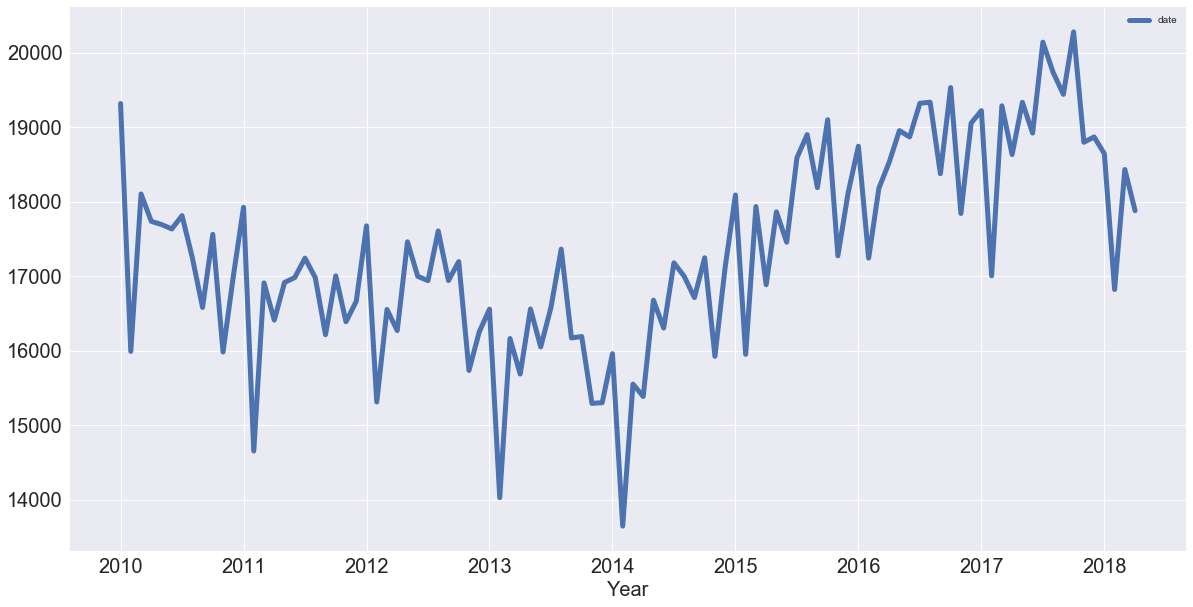

In [70]:
crime_df['date'] = crime_df['date_occ'].str[0:10]
time_format = '%Y-%m-%d'
crime_df['date'] = pd.to_datetime(crime_df['date'], format = time_format)
time_df = crime_df.loc[:, ['date']]
time_df = time_df.loc[~(time_df['date'].dt.month.eq(5) & time_df['date'].dt.year.eq(2018))]
time_df.index = time_df['date']
time_df.resample('M').count().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

## Crimes and Weapons Used

In [13]:
#The ten most frequent crimes in LA since 2010
crime_df.groupby('crm_cd_desc').crm_cd.count().sort_values(ascending=False).head(10)

crm_cd_desc
BATTERY - SIMPLE ASSAULT                                        158983
BURGLARY FROM VEHICLE                                           133892
VEHICLE - STOLEN                                                133720
BURGLARY                                                        125101
THEFT PLAIN - PETTY ($950 & UNDER)                              123768
THEFT OF IDENTITY                                               109031
INTIMATE PARTNER - SIMPLE ASSAULT                                94144
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS) 0114     88118
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                         77361
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT                   74619
Name: area_name, dtype: int64

To identify what weapons are frequently used, I will isolate the crime_cd_desc "Assault with deadly weapon, aggravated assault" and get counts for the different weapons used.

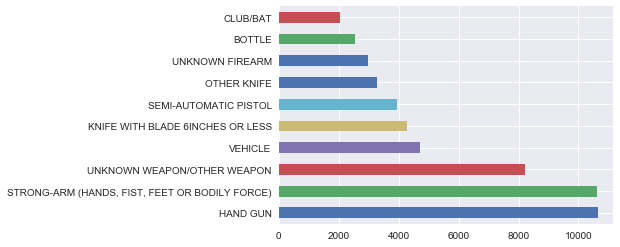

In [37]:
weapons = crime_df[crime_df['crm_cd']=='230']
weapons.groupby('weapon_desc').crm_cd.count().sort_values(ascending=False).head(10)
weapons['weapon_desc'].value_counts()[:10].plot(kind='barh')

From the plot above one can see that hand guns are the most used weapon in crimes coded as "Assault with deadly weapon, aggravated assault". Los Angeles has an anonomyous gun buy back program. Perhaps by creating similar programs or increasing awareness of the program would reduce the number of assaults with the use of a gun.

## Crimes by Location

{'01': 'Central', '02': 'Rampart', '03': 'Southwest', '19': 'Mission', '04': 'Hollenbeck', '05': 'Harbor', '06': 'Hollywood', '07': 'Wilshire', '08': 'West LA', '09': 'Van Nuys', '10': 'West Valley', '11': 'Northeast', '12': '77th Street', '13': 'Newton', '14': 'Pacific', '15': 'N Hollywood', '16': 'Foothill', '17': 'Devonshire', '18': 'Southeast', '20': 'Olympic', '21': 'Topanga'}


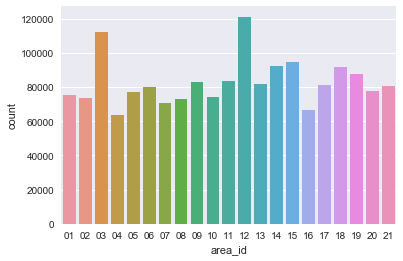

In [8]:
#Identify how crimes are spread thoughout Los Angeles
area_ids = crime_df.area_id.unique()
area_names = crime_df.area_name.unique()
area_dict = dict(zip(area_ids, area_names))
print(area_dict)
sns.set(style="darkgrid")
ax = sns.countplot(x='area_id', data = crime_df)

Areas with significantly more crimes are "77th street" and the "Southwest region". From this graph we can not tell if this is a result of those areas containing a larger share of LA's population. To test this I will use a proportion test using data taken from the LAPD's website. According to the website the 77th street area has a population of approximately 175,000. According to the United States Census Bureau Los Angles has a population of approxiately 3,976,000. To test if the 77th street area is more prone to crime I will do a proportion z test. http://www.lapdonline.org/77th_street_community_police_station/content_basic_view/1573

In [50]:
total_count = crime_df.crm_cd.count()
count_77 = crime_df[crime_df['area_id']=='12']['crm_cd'].count()
z_score, p_value = sm.stats.proportions_ztest([count_77, 175000], [total_count, 3976000])
print(z_score, p_value)

-489.8559815792213 0.0


## When Crimes Occur

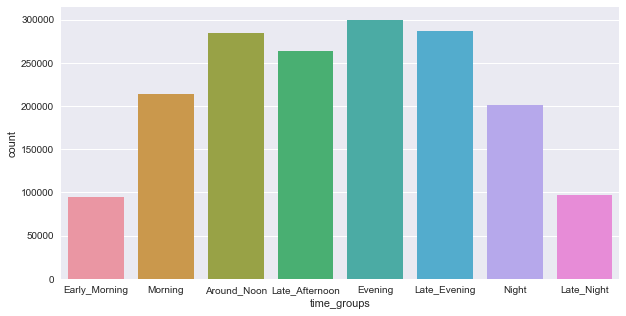

In [51]:
#Put the time crimes occur into buckets
crime_df['time'] = pd.to_numeric(crime_df['time_occ'])
def label_time(row):
    if 500 <= row < 800:
        return 'Early_Morning'
    elif 800 <= row < 1100:
        return 'Morning'
    elif 1100 <= row < 1400:
        return 'Around_Noon'
    elif 1400 <= row < 1700:
        return 'Late_Afternoon'
    elif 1700 <= row < 2000:
        return 'Evening'
    elif 2000 <= row < 2300:
        return 'Late_Evening'
    elif 2300 <= row <= 2400 or 0 <= row < 200:
        return 'Night'
    elif 200 <= row < 500:
        return 'Late_Night'
    else:
        return 'Other'
crime_df['time_groups'] = crime_df['time'].apply(label_time)
plt.figure(figsize=(10,5))
axis = sns.countplot(x = 'time_groups', data = crime_df, order = ['Early_Morning', 'Morning', 'Around_Noon', 'Late_Afternoon', 'Evening', 'Late_Evening', 'Night', 'Late_Night'])

## Victim Demographics

In [16]:
#Convert age to numerics and see the description of the age column
crime_df['age'] = pd.to_numeric(crime_df['vict_age'])
print(crime_df['age'].describe())

count    911904.000000
mean         35.790354
std          16.779279
min          10.000000
25%          23.000000
50%          34.000000
75%          47.000000
max          99.000000
Name: age, dtype: float64


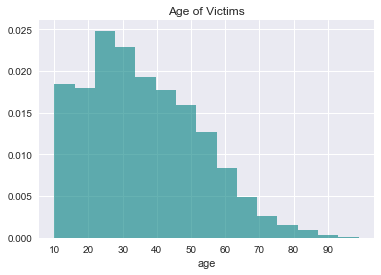

In [17]:
#Examine the distribution of age for victims
plt.xlabel('age')
plt.title('Age of Victims')
plt.xticks(range(0, 100, 10))
plt.hist(crime_df['age'].dropna(), bins=15, density = True, stacked = True, color = 'teal', alpha = .6)
plt.show()

From this histogram we can see that the portion of the population that are the most victimized are teenagers and the risk of victimization appears to drop as individuals get older.

In [18]:
counts = crime_df.groupby(['vict_descent', 'vict_sex'])['crm_cd'].count().unstack('vict_sex').fillna(0)
print(counts)

vict_sex        -         F     H         M        X
vict_descent                                        
-             0.0       0.0   0.0       1.0      0.0
A             0.0   11746.0   2.0   11057.0      1.0
B             0.0   95744.0   3.0   67859.0      3.0
C             0.0     170.0   0.0     169.0      2.0
D             0.0       6.0   0.0       6.0      0.0
F             1.0     666.0   7.0     572.0      0.0
G             0.0      22.0   0.0      10.0      0.0
H             0.0  176055.0  13.0  170042.0      6.0
I             0.0     122.0   0.0     278.0      0.0
J             0.0      87.0   0.0      71.0      0.0
K             0.0    2066.0   1.0    2222.0      0.0
L             0.0       4.0   0.0       3.0      0.0
O             0.0   32336.0   2.0   62660.0      8.0
P             0.0      99.0   0.0      60.0      0.0
S             0.0       9.0   0.0       9.0      0.0
U             0.0      39.0   0.0      47.0      0.0
V             0.0      33.0   0.0      30.0   

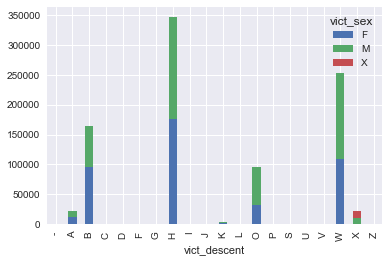

In [19]:
counts[['F', 'M', 'X']].plot(kind='bar', stacked = True)

Victims are more likely to be hispanic, white, or black. The counts of male and female victims are roughly equal with there being slightly more males.

In [42]:
crime_df[crime_df['mocodes'].str.contains('1218', na=False)]

,area_id,area_name,crm_cd,crm_cd_desc,date_occ,date_rptd,dr_no,location,location_1,mocodes,...,time_occ,vict_age,vict_descent,vict_sex,weapon_desc,weapon_used_cd,time,time_groups,age,date
374,01,Central,626,INTIMATE PARTNER - SIMPLE ASSAULT,2016-01-29T00:00:00.000,2016-01-30T00:00:00.000,160106442,5TH ST,"{'type': 'Point', 'coordinates': [-118.2502, 3...",0416 0417 1218 2000,...,0935,45,W,M,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400,935,Morning,45.0,2016-01-29
414,04,Hollenbeck,821,SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO...,2016-10-31T00:00:00.000,2016-10-31T00:00:00.000,160401250,1200 PLEASANT AV,"{'type': 'Point', 'coordinates': [-118.2227, 3...",1402 1415 1218 0913 0519 0545,...,0100,19,H,M,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400,100,Night,19.0,2016-10-31
446,05,Harbor,121,"RAPE, FORCIBLE",2016-09-05T00:00:00.000,2016-10-05T00:00:00.000,160517698,500 N WESTERN AV,"{'type': 'Point', 'coordinates': [-118.3092, 3...",0400 0527 1218 1259 1822,...,0300,15,H,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400,300,Late_Night,15.0,2016-09-05
450,06,Hollywood,440,THEFT PLAIN - PETTY ($950 & UNDER),2016-03-01T00:00:00.000,2016-03-06T00:00:00.000,160608176,HOLLYWOOD BL,"{'type': 'Point', 'coordinates': [-118.3093, 3...",0344 1218,...,2000,32,B,M,NaN,NaN,2000,Late_Evening,32.0,2016-03-01
673,20,Olympic,624,BATTERY - SIMPLE ASSAULT,2016-03-07T00:00:00.000,2016-03-07T00:00:00.000,162007262,HOOVER ST,"{'type': 'Point', 'coordinates': [-118.2842, 3...",2004 1218 0416 0446,...,0300,57,H,M,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400,300,Late_Night,57.0,2016-03-07
758,01,Central,930,CRIMINAL THREATS - NO WEAPON DISPLAYED,2017-01-06T00:00:00.000,2017-01-06T00:00:00.000,170104359,500 MAPLE AV,"{'type': 'Point', 'coordinates': [-118.2466, 3...",2004 1218 0443 0334,...,0005,44,H,F,VERBAL THREAT,511,5,Night,44.0,2017-01-06
765,01,Central,110,CRIMINAL HOMICIDE,2017-02-12T00:00:00.000,2017-02-12T00:00:00.000,170106659,CENTRAL,"{'type': 'Point', 'coordinates': [-118.2397, 3...",1100 0430 1218 0906 2004,...,0317,42,H,M,HAND GUN,102,317,Late_Night,42.0,2017-02-12
778,01,Central,626,INTIMATE PARTNER - SIMPLE ASSAULT,2017-04-24T00:00:00.000,2017-04-24T00:00:00.000,170112335,500 S BROADWAY,"{'type': 'Point', 'coordinates': [-118.2507, 3...",2000 0305 0444 0429 0448 1241 0319 1813 1218 2004,...,0300,28,H,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",400,300,Late_Night,28.0,2017-04-24
781,01,Central,440,THEFT PLAIN - PETTY ($950 & UNDER),2017-04-28T00:00:00.000,2017-04-29T00:00:00.000,170112893,6TH,"{'type': 'Point', 'coordinates': [-118.2443, 3...",1218 0913,...,0630,45,B,F,NaN,NaN,630,Early_Morning,45.0,2017-04-28
820,01,Central,110,CRIMINAL HOMICIDE,2017-06-25T00:00:00.000,2017-06-25T00:00:00.000,170118021,4TH ST,"{'type': 'Point', 'coordinates': [-118.2447, 3...",1402 0430 0906 2004 1218 0930 1100,...,0650,43,B,M,UNKNOWN FIREARM,106,650,Early_Morning,43.0,2017-06-25
